## Creat an 2D IR SE for T1 mapping

Sample the longitudinal magnetization recovery curve for T1 mapping



*   Define parameters (Ny,Nx, TR, TE and Inversion times - TI)
*   Generate the 2D SE module for the readout
*   Generate the Inveriosn pulse
*   Generate the sequence with 5 TIs and respective timings


In order to be able to properly sample trhe recovery curve: TR>5*T1



In [5]:
pip install pypulseq

### Import libraries



*   Pulseq functions
*   Libraries for calculations



In [7]:
## Import libraries
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import os

from pypulseq.Sequence.sequence import Sequence
from pypulseq.calc_rf_center import calc_rf_center
from pypulseq.make_adc import make_adc
from pypulseq.make_delay import make_delay
from pypulseq.make_extended_trapezoid import make_extended_trapezoid
from pypulseq.make_adiabatic_pulse import make_adiabatic_pulse
from pypulseq.make_trapezoid import make_trapezoid
from pypulseq.opts import Opts
from pypulseq.calc_duration import calc_duration
from pypulseq.make_sinc_pulse import make_sinc_pulse


## Define parameters and sysmet requirements




In [8]:
# Define Geometry
Nx, Ny, Nz = [128, 128, 1]

slice_thickness = 8e-3 # Slice thickness
fov = [0.256, 0.256, Nz*slice_thickness]  # Define FOV and resolution
TE  = 15e-3    # Echo time [s]
TR  = 5000e-3    # Repetition time [s]
TI  = [50e-3, 100e-3, 500e-3, 1500e-3, 4500e-3] # Inversion time [s]


# Set the scanner hardware requirements
system = Opts( max_grad = 28, grad_unit="mT/m",max_slew = 120, slew_unit="T/m/s",
    grad_raster_time = 10e-6,  # [s]
    rf_raster_time   = 1e-6 ,    # [s]
    rf_ringdown_time = 20e-6,  # [s]
    rf_dead_time     = 100e-6,      # [s]
    adc_dead_time    = 10e-6 ,     # [s]
)

## Define SE module for the readout



*   Readout gradients
*   Excitation and refocusing pulses
*   Spoiler gradients
*   Delays




In [ ]:
def SE_module(seq, fov=200e-3, Nx =128, Nz =1, Ny=128, TE  = 15e-3,
              TR  = 5000e-3,ky_i=0):
    """
    Creates a Spin-echo module (SE) sequence and adds it
    to the seq object

    Parameters
    ----------
    seq: object
        Sequence object
    fov : float, optional
        Field-of-view [m]. Default is 0.2 m.
    Nx, Ny, Nz : float, optional
        Ny - Number of phase encoding lines. Default is 128.
    TE: Echo time [s]
    TR: Repetition Time [s]
    ky_i: line in k-space
   Returns
    -------
    seq : SimpleNamespace
        Seq object with bSSFP readout
    TR : float
        Repetition time
    Ny : float
    time_remove_TI: foat
                    time for TI delay calculation
    remove_delayTR: float
                    time for TR delay calculation
    """
    ETL = 1   # Echo Train Length
    readout_time =  6.4e-3  # ADC duration
    TE = TE*np.arange(1, ETL+1) # [s]
    # Readout gradients
    delta_k = 1 / fov[0]
    k_width = (Nx) * delta_k
    gx = make_trapezoid(channel='x', system=system, flat_area=k_width,
                    flat_time = readout_time)
    adc = make_adc(num_samples=Nx, duration=readout_time, delay=gx.rise_time)

    gx_pre = make_trapezoid(channel='x', system=system, area=(gx.area) / 2)
    gx_post = make_trapezoid(channel='x', system=system, area=3 * gx.area / 2)

    # Prephase and rephase
    phase_areas = np.linspace(-0.5*delta_k*Ny, 0.5*delta_k*Ny, Ny)
    gy_pe_max = make_trapezoid(channel='y', system=system, area=np.max(np.abs(phase_areas)))
    pe_duration = calc_duration(gy_pe_max)

    rf_flip = 90
    rf_offset = 0

    flip90 = round(rf_flip * pi / 180, 3)
    flip180 = 180 * pi / 180
    rf90, gz90, gz_reph = make_sinc_pulse(flip_angle=flip90, system=system, duration=2.5e-3,
                                      slice_thickness=slice_thickness, apodization=0.5,
                                      phase_offset=pi / 2,
                                      time_bw_product=4, return_gz=True, use="excitation")

    rf180, gz180, _ = make_sinc_pulse(flip_angle=flip180, system=system,
                                      duration=2.5e-3,
                                      slice_thickness=1.25 * slice_thickness,
                                      apodization=0.5,
                                      time_bw_product=4, phase_offset=0,
                                      return_gz=True, use="refocusing")



    # Spoiler
    gss_spoil_A = 4 / slice_thickness
    gss_spoil = make_trapezoid(channel='z', system=system, area=gss_spoil_A)

    gss_times = np.cumsum([0, gss_spoil.rise_time, gss_spoil.flat_time,
                           gss_spoil.fall_time - gz180.rise_time, gz180.flat_time,
                           gss_spoil.rise_time - gz180.fall_time,
                           gss_spoil.flat_time, gss_spoil.fall_time])

    gss_amps = np.array(
            [0, gss_spoil.amplitude, gss_spoil.amplitude, gz180.amplitude, gz180.amplitude, gss_spoil.amplitude,
             gss_spoil.amplitude, 0])

    gss_spoil_add=make_extended_trapezoid(channel='z', amplitudes=gss_amps, times=gss_times, system=system)

    rf180.delay = gss_spoil.rise_time + gss_spoil.flat_time + gss_spoil.fall_time - gz180.rise_time

    gss_spoil_duration = calc_duration(gss_spoil_add)

    # End of TR spoiler
    gz_spoil = make_trapezoid(channel='z', system=system, area=2 / slice_thickness)
    gz_spoil.id = seq.register_grad_event(gz_spoil)

    # Delays
    # Echo time (TE) and repetition time (TR)
    pre180d = (TE[0] / 2
               - calc_duration(gz90) / 2
               - calc_duration(gx_pre, gz_reph)
                          - gss_spoil_duration / 2
                          )
    post180d = (TE[0] / 2
                - gss_spoil_duration / 2
                - pe_duration
                - (gx.rise_time + readout_time / 2)
                            )

    pre180delay = make_delay(pre180d)
    post180delay= make_delay(post180d)

    gz_s = make_trapezoid(channel='z', system=seq.system, area=-4 / slice_thickness)
    gx_s = make_trapezoid(channel='x', system=seq.system, area=-4 / slice_thickness)
    gy_s = make_trapezoid(channel='y', system=seq.system, area=-4 / slice_thickness)


    time_remove_TI=calc_duration(gz90) +calc_duration(gz_reph) + calc_duration(gz180) + calc_duration(gss_spoil_add)-gz180.rise_time -calc_duration(gx_s, gy_s, gz_s)
    remove_delayTR =  time_remove_TI++calc_duration(gx_post)  + readout_time + pre180d


    gy_pre= make_trapezoid(channel='y', system=system,
                                 area=phase_areas[-ky_i - 1], duration=pe_duration)
    gy_post= make_trapezoid(channel='y', system=system,
                                  area=-phase_areas[-ky_i - 1], duration=pe_duration)

    # Build sequence block SE
    seq.add_block(gz_s,gx_s,gy_s)
    seq.add_block(rf90, gz90)
    seq.add_block(gx_pre, gz_reph)

    seq.add_block(pre180delay)
    seq.add_block(rf180, gss_spoil_add)
    seq.add_block(post180delay)


    seq.add_block(gy_pre)

    seq.add_block(gx, adc)
    seq.add_block(gy_post)

    seq.add_block(gx_post, gz_spoil)

    return seq, TR, Ny, time_remove_TI, remove_delayTR

# Generate IR SE block

In this section the inversion pulse is created. The block for each image acquisition (corresponds to each TI) are added to the sequence.

In [19]:
# Delay
seqa = Sequence(system)

# Export delays for TR and TI
_, _, _, time_remove_TI, remove_delayTR = SE_module(seqa, fov=fov, Nx =Nx, Nz =Nz, Ny=Ny, TE  = TE,
                            TR  = TR,ky_i=0)

delay_TR = TR - remove_delayTR

TId = TI - time_remove_TI

# Generate sequence
seq = Sequence(system)

# Inversion Pulse
rf180inv, gz180inv, _ = make_adiabatic_pulse(
    pulse_type='hypsec',
    duration=8e-3, beta=800,
    slice_thickness=slice_thickness, mu=4.9,
    return_gz=True, system=seq.system, use="inversion"
    )



for nTI in TId:
  for ky_i in range(Ny):
    seq.add_block(make_delay(delay_TR - nTI))
    seq.add_block(rf180inv, gz180inv)
    seq.add_block(make_delay(nTI))
    ##########################################################################################
    # SE module
    seq, TR, _,_,_ = SE_module(seq, fov=fov, Nx =Nx, Nz =Nz, Ny=Ny, TE  = TE,
                            TR  = TR,ky_i=ky_i)
    ##########################################################################################



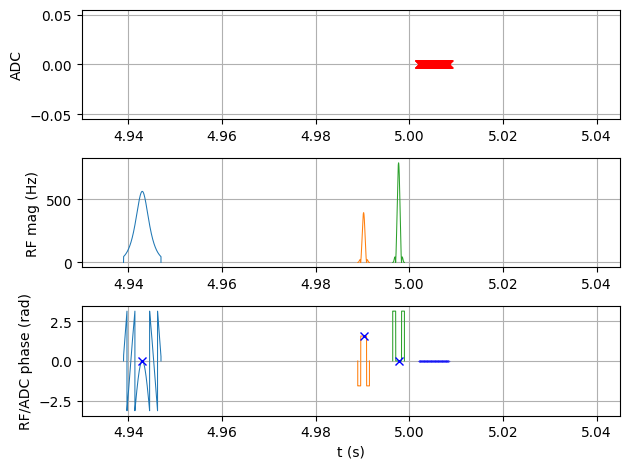

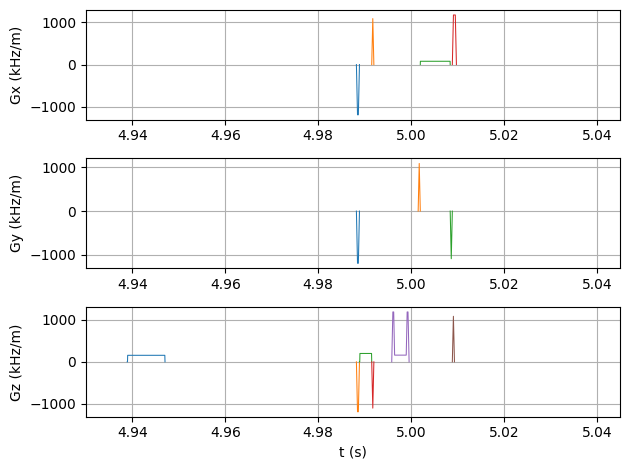

In [23]:
# ======
# VISUALIZATION
# ======
seq.plot(time_range=(TR-0.07, TR+0.045))

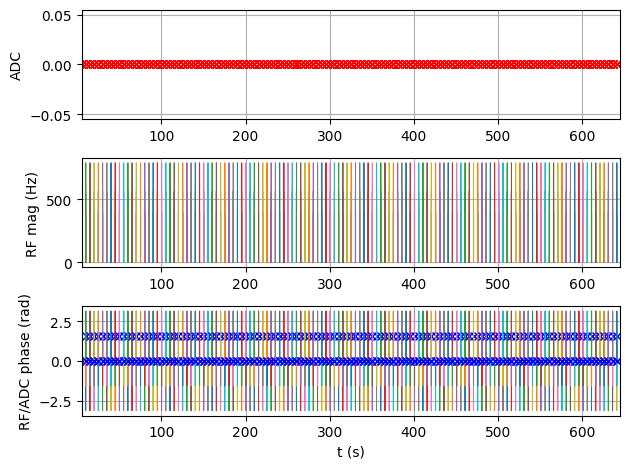

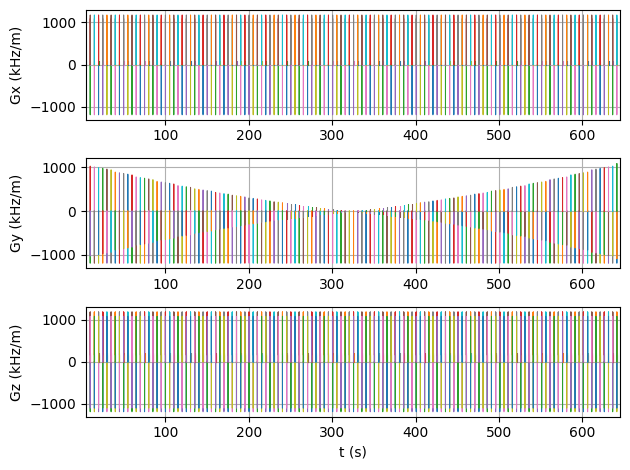

In [24]:
# Plot MR sequence for fisrt T1-weighted image
seq.plot(time_range=(TR, TR+TR*Ny))

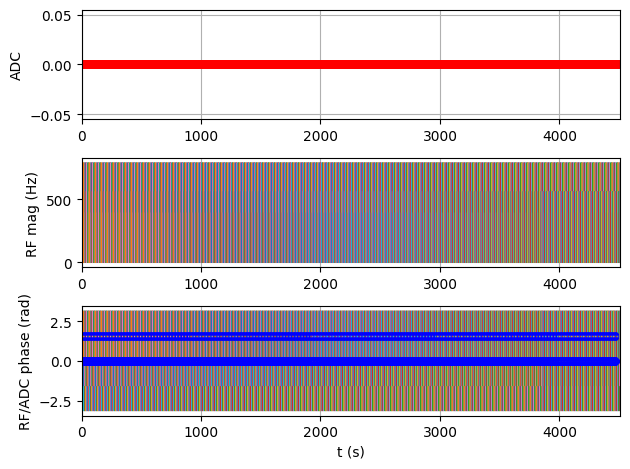

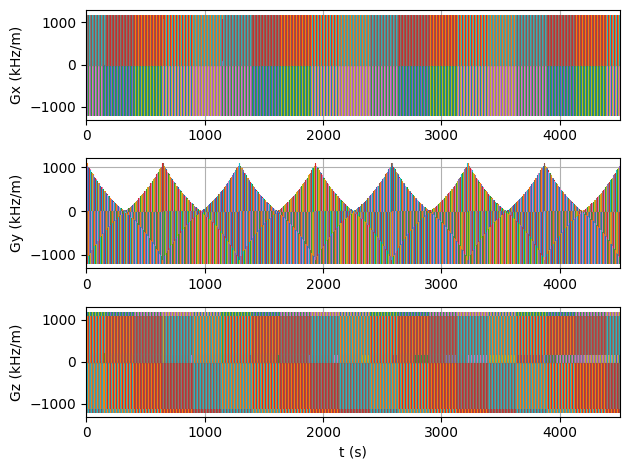

In [ ]:
#Plot complete MR sequence for images with diferent time of inversion
seq.plot()


In [26]:
seq.set_definition(key="FOV", value=fov)
seq.set_definition(key="Name", value="irse2d")
seq.set_definition(key="TE", value=TE)
seq.set_definition(key="ReconMatrixSize", value=[Nx, Ny, 1])
seq.set_definition(key="TR", value=TR)
seq.write('IRSE_T1mapping.seq')

seq_to_write = copy.deepcopy(seq)
seq_to_write.write('IRSE_T1mapping.seq')

from google.colab import files
# Download Colab VM fiels to local
files.download('IRSE_T1mapping.seq')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>